### Comparison of LSTM, Random Forest and Multi-Layer Perceptron Code

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import torch
import torch.nn as nn
from tensorflow import keras
import joblib


In [5]:
# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300

# ============================================================================
# CONFIGURATION
# ============================================================================

# File paths
DATA_PATH = 'C:/Users/cario/OneDrive/Desktop/GSI_Performance_ML/data/raw/filtered_storms_df.csv'
MODEL_DIR = 'C:/Users/cario/OneDrive/Desktop/GSI_Performance_ML/results/models'
FIGURE_DIR = 'C:/Users/cario/OneDrive/Desktop/GSI_Performance_ML/results/figures'

# Model paths
MLP_PATH = f'{MODEL_DIR}/mlp_model.pth'
LSTM_PATH = f'{MODEL_DIR}/lstm_model.keras'
RF_PATH = f'{MODEL_DIR}/rf_model.joblib'

# Create figures directory if needed
import os
os.makedirs(FIGURE_DIR, exist_ok=True)


In [6]:

# ============================================================================
# LOAD DATA
# ============================================================================
df = pd.read_csv(DATA_PATH)
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)
input_columns = [
    'Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91',
    'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)', 'Previous_Dry_Days',
    'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'StormID'
]
target_column = 'Recession_Rate (mm/s)'

# Test storm IDs (same as in your training)
test_storm_ids = {12, 14, 40, 20, 57, 52, 61, 65, 70, 85, 95, 163, 158, 171, 115,
                  200, 231, 221, 237, 244, 273, 277, 261, 296, 299, 304, 305, 325,
                  326, 214, 205}

# Split data
test_df = df[df['StormID'].isin(test_storm_ids)]
train_df = df[~df['StormID'].isin(test_storm_ids)]

X_train = train_df[input_columns]
y_train = train_df[target_column]
X_test = test_df[input_columns]
y_test = test_df[target_column]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train set: {X_train_scaled.shape[0]} samples")
print(f"Test set: {X_test_scaled.shape[0]} samples")


Train set: 42065 samples
Test set: 17080 samples


In [11]:

# ============================================================================
# LOAD MODELS
# ============================================================================

class MLPRegressor(nn.Module):
    def __init__(self, input_size, hidden_sizes=[64, 32], dropout_rate=0.2):
        super(MLPRegressor, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(hidden_sizes[-1], 1))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

mlp_checkpoint = torch.load(MLP_PATH,weights_only=False)
mlp_model = MLPRegressor(
    input_size=mlp_checkpoint['input_size'],
    hidden_sizes=mlp_checkpoint['hidden_sizes'],
    dropout_rate=mlp_checkpoint['dropout_rate']
)
mlp_model.load_state_dict(mlp_checkpoint['model_state_dict'])
mlp_model.eval()

# 2. Load LSTM Model
lstm_model = keras.models.load_model(LSTM_PATH)

# 3. Load RF Model
rf_model = joblib.load(RF_PATH)


In [13]:

# ============================================================================
# MAKE PREDICTIONS
# ============================================================================

# MLP Predictions
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)

with torch.no_grad():
    y_train_pred_mlp = mlp_model(X_train_tensor).numpy().flatten()
    y_test_pred_mlp = mlp_model(X_test_tensor).numpy().flatten()

# LSTM Predictions (needs reshaping for timesteps)
timesteps = 2
n_features = X_train_scaled.shape[1]

# Reshape for LSTM
X_train_lstm = np.array([X_train_scaled[i-timesteps:i] for i in range(timesteps, len(X_train_scaled))])
X_test_lstm = np.array([X_test_scaled[i-timesteps:i] for i in range(timesteps, len(X_test_scaled))])

y_train_lstm = y_train.iloc[timesteps:].reset_index(drop=True)
y_test_lstm = y_test.iloc[timesteps:].reset_index(drop=True)

y_train_pred_lstm = lstm_model.predict(X_train_lstm, verbose=0).flatten()
y_test_pred_lstm = lstm_model.predict(X_test_lstm, verbose=0).flatten()

# RF Predictions
y_train_pred_rf = rf_model.predict(X_train_scaled)
y_test_pred_rf = rf_model.predict(X_test_scaled)



In [14]:

# ============================================================================
# COMPUTE METRICS
# ============================================================================

def compute_metrics(y_true, y_pred, model_name, dataset_name):
    """Compute all metrics for a model"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)
    
    return {
        'Model': model_name,
        'Dataset': dataset_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'EVS': evs
    }

# Compute metrics for all models
results = []

# MLP
results.append(compute_metrics(y_train, y_train_pred_mlp, 'MLP', 'Train'))
results.append(compute_metrics(y_test, y_test_pred_mlp, 'MLP', 'Test'))

# LSTM
results.append(compute_metrics(y_train_lstm, y_train_pred_lstm, 'LSTM', 'Train'))
results.append(compute_metrics(y_test_lstm, y_test_pred_lstm, 'LSTM', 'Test'))

# RF
results.append(compute_metrics(y_train, y_train_pred_rf, 'RF', 'Train'))
results.append(compute_metrics(y_test, y_test_pred_rf, 'RF', 'Test'))

# Create results DataFrame
results_df = pd.DataFrame(results)


In [ ]:

# ============================================================================
# DISPLAY RESULTS
# ============================================================================

print("\n" + "="*80)
print("MODEL COMPARISON RESULTS")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# Save results to CSV
results_df.to_csv(f'{FIGURE_DIR}/model_comparison_results.csv', index=False)



MODEL COMPARISON RESULTS
Model Dataset      MSE     RMSE      MAE       R²      EVS
  MLP   Train 0.000053 0.007265 0.003729 0.687317 0.687899
  MLP    Test 0.000085 0.009244 0.003740 0.602459 0.604747
 LSTM   Train 0.000038 0.006185 0.003234 0.773384 0.774563
 LSTM    Test 0.000054 0.007356 0.003130 0.748313 0.748535
   RF   Train 0.000035 0.005878 0.003245 0.795342 0.795342
   RF    Test 0.000084 0.009139 0.003760 0.611408 0.611665


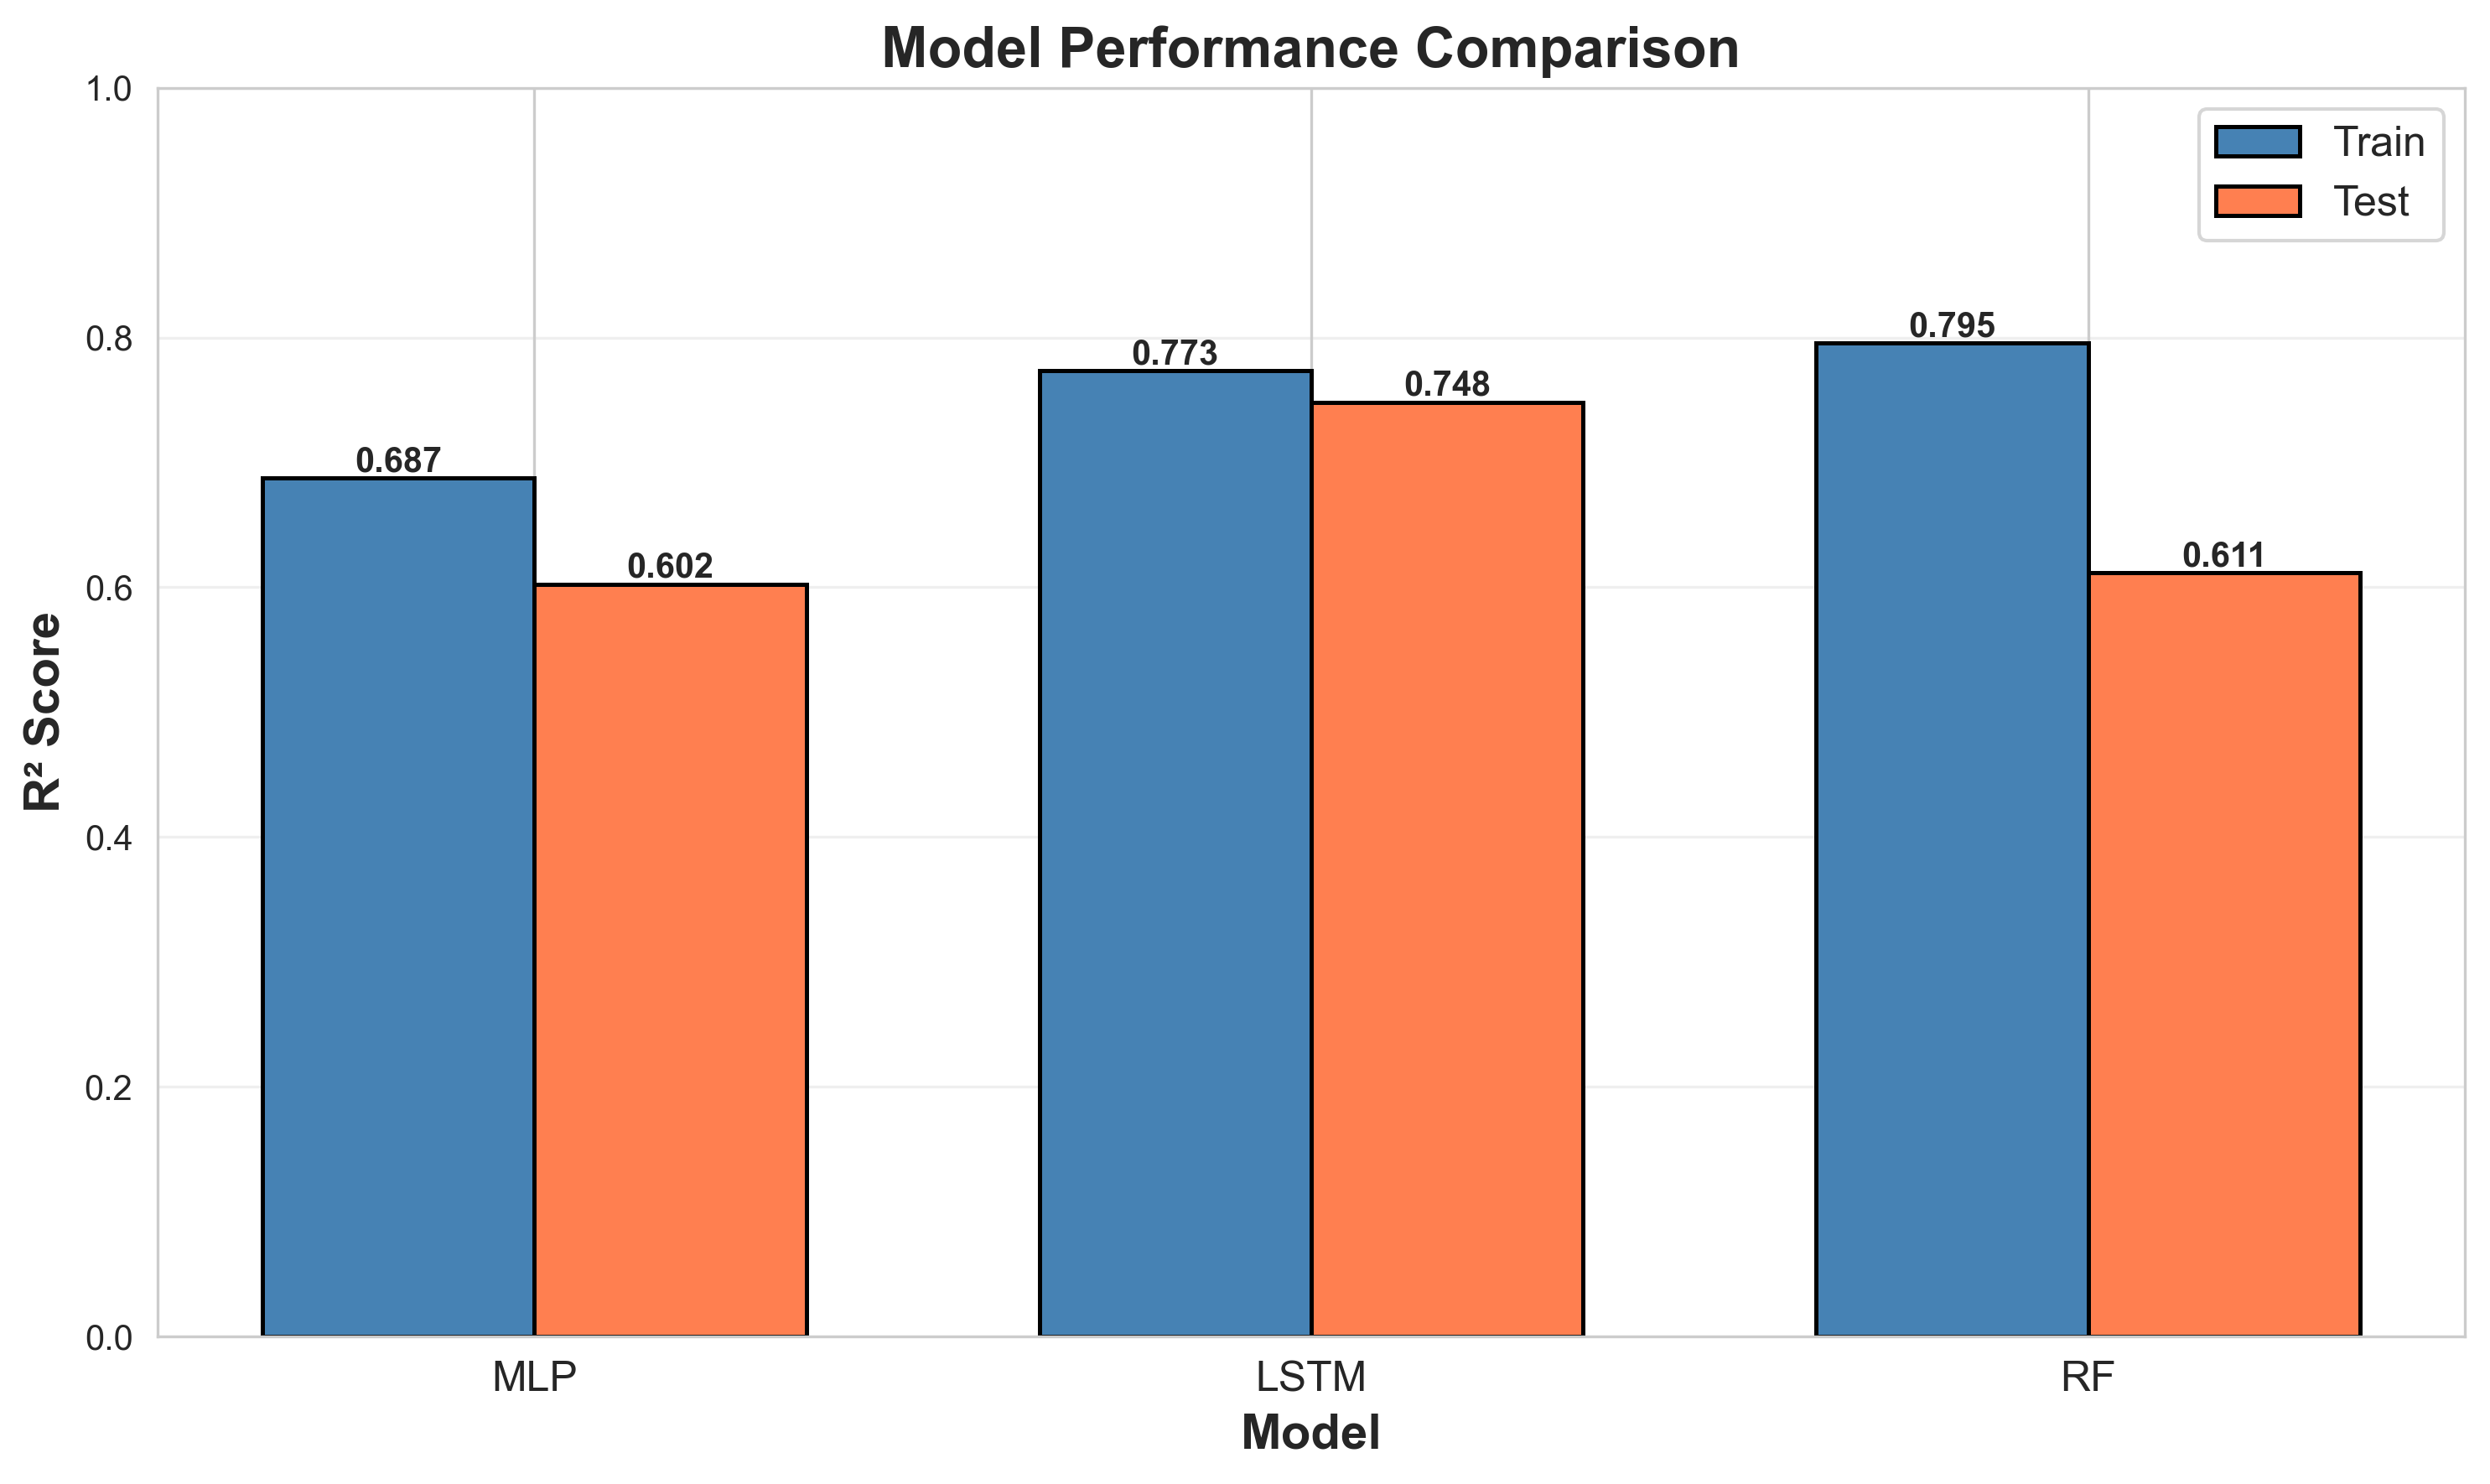

In [16]:

# ============================================================================
# VISUALIZATION 1: R² COMPARISON BAR CHART
# ============================================================================


fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data
train_results = results_df[results_df['Dataset'] == 'Train']
test_results = results_df[results_df['Dataset'] == 'Test']

x = np.arange(len(train_results))
width = 0.35

# Create bars
bars1 = ax.bar(x - width/2, train_results['R²'], width, label='Train', 
               color='steelblue', edgecolor='black', linewidth=1.2)
bars2 = ax.bar(x + width/2, test_results['R²'], width, label='Test', 
               color='coral', edgecolor='black', linewidth=1.2)

# Customize plot
ax.set_xlabel('Model', fontsize=14, fontweight='bold')
ax.set_ylabel('R² Score', fontsize=14, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(train_results['Model'], fontsize=12)
ax.legend(fontsize=12)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

# Add value labels on bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

add_value_labels(bars1)
add_value_labels(bars2)

plt.tight_layout()
plt.savefig(f'{FIGURE_DIR}/model_comparison_r2.png', dpi=300, bbox_inches='tight')
plt.show()


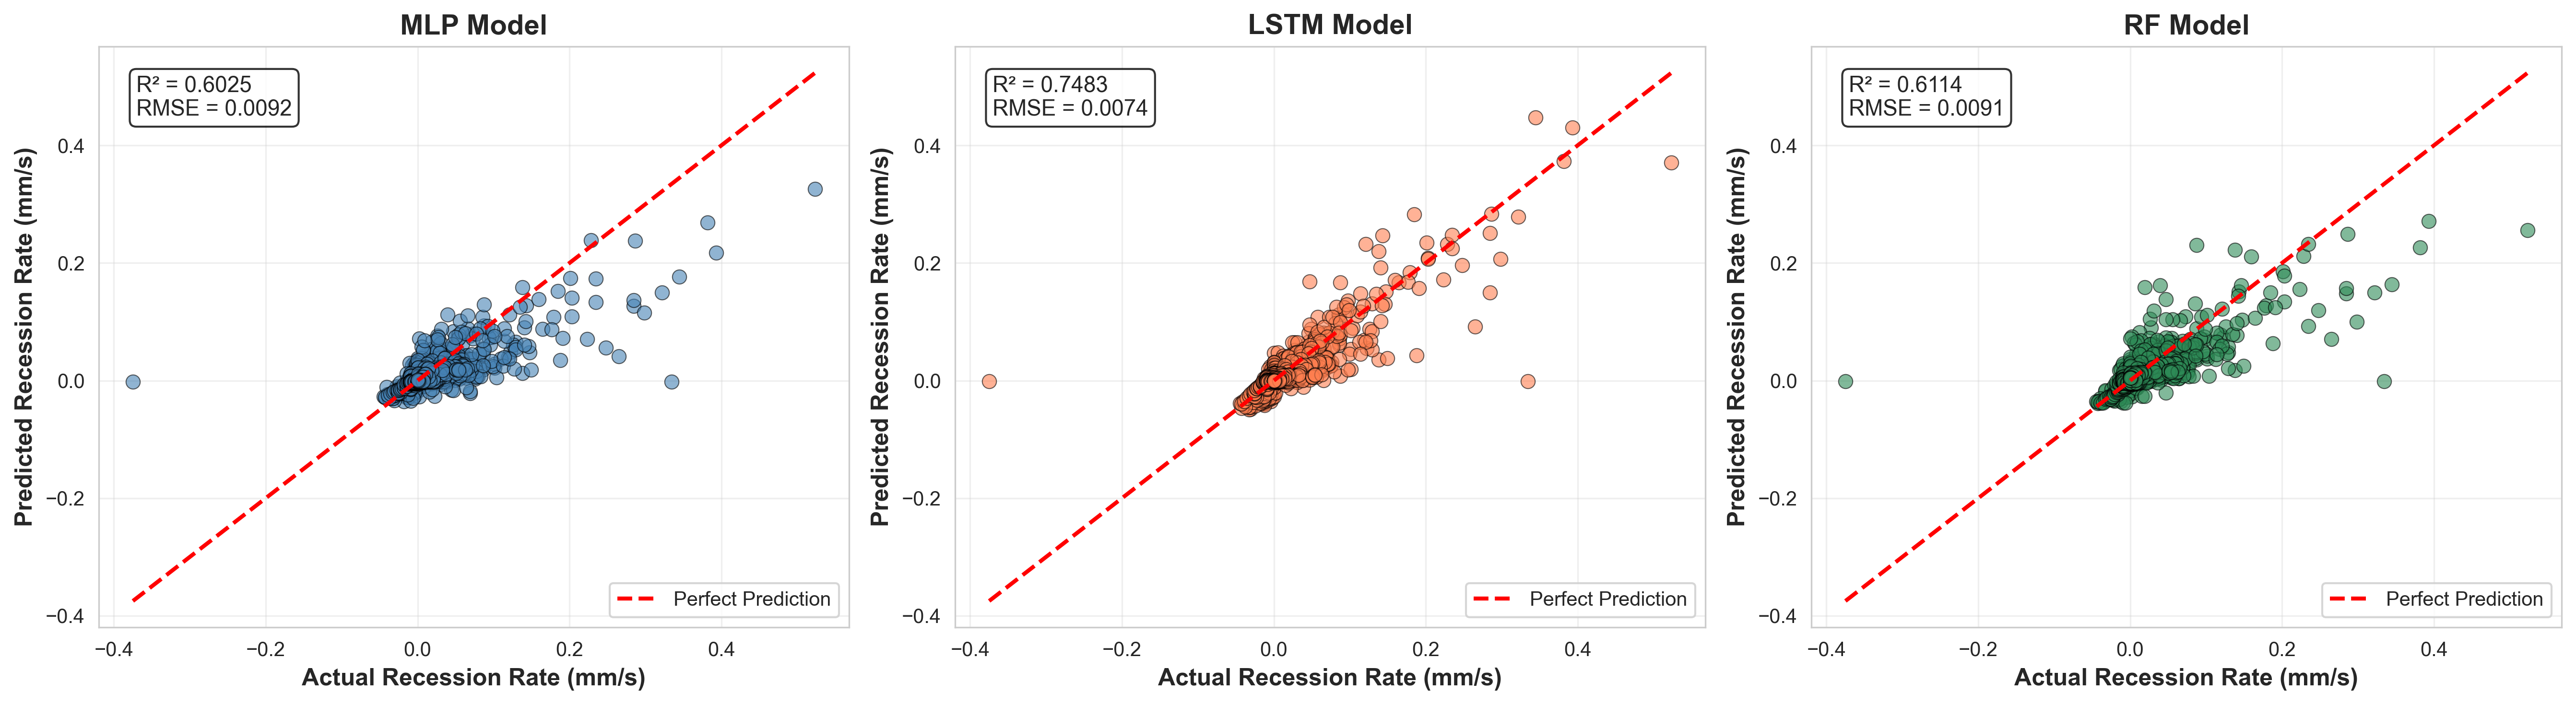

In [18]:

# ============================================================================
# VISUALIZATION 2: SCATTER PLOT - ACTUAL VS PREDICTED (ALL MODELS)
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_data = [
    ('MLP', y_test, y_test_pred_mlp, 'steelblue'),
    ('LSTM', y_test_lstm, y_test_pred_lstm, 'coral'),
    ('RF', y_test, y_test_pred_rf, 'seagreen')
]

for idx, (model_name, y_true, y_pred, color) in enumerate(models_data):
    ax = axes[idx]
    
    # Scatter plot
    ax.scatter(y_true, y_pred, alpha=0.6, s=50, c=color, edgecolors='black', linewidth=0.5)
    
    # Perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    # Compute R² for this model
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Add metrics text box
    text_msg = f"R² = {r2:.4f}\nRMSE = {rmse:.4f}"
    ax.text(0.05, 0.95, text_msg, transform=ax.transAxes,
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='black'))
    
    ax.set_xlabel('Actual Recession Rate (mm/s)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Predicted Recession Rate (mm/s)', fontsize=12, fontweight='bold')
    ax.set_title(f'{model_name} Model', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{FIGURE_DIR}/model_comparison_scatter.png', dpi=300, bbox_inches='tight')
plt.show()


C:\Users\cario\AppData\Local\Temp\ipykernel_1900\799321088.py:36: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(x_indices, y_storm, 'ko-', color='gray', linewidth=1, markersize=2, label='Actual', zorder=5)


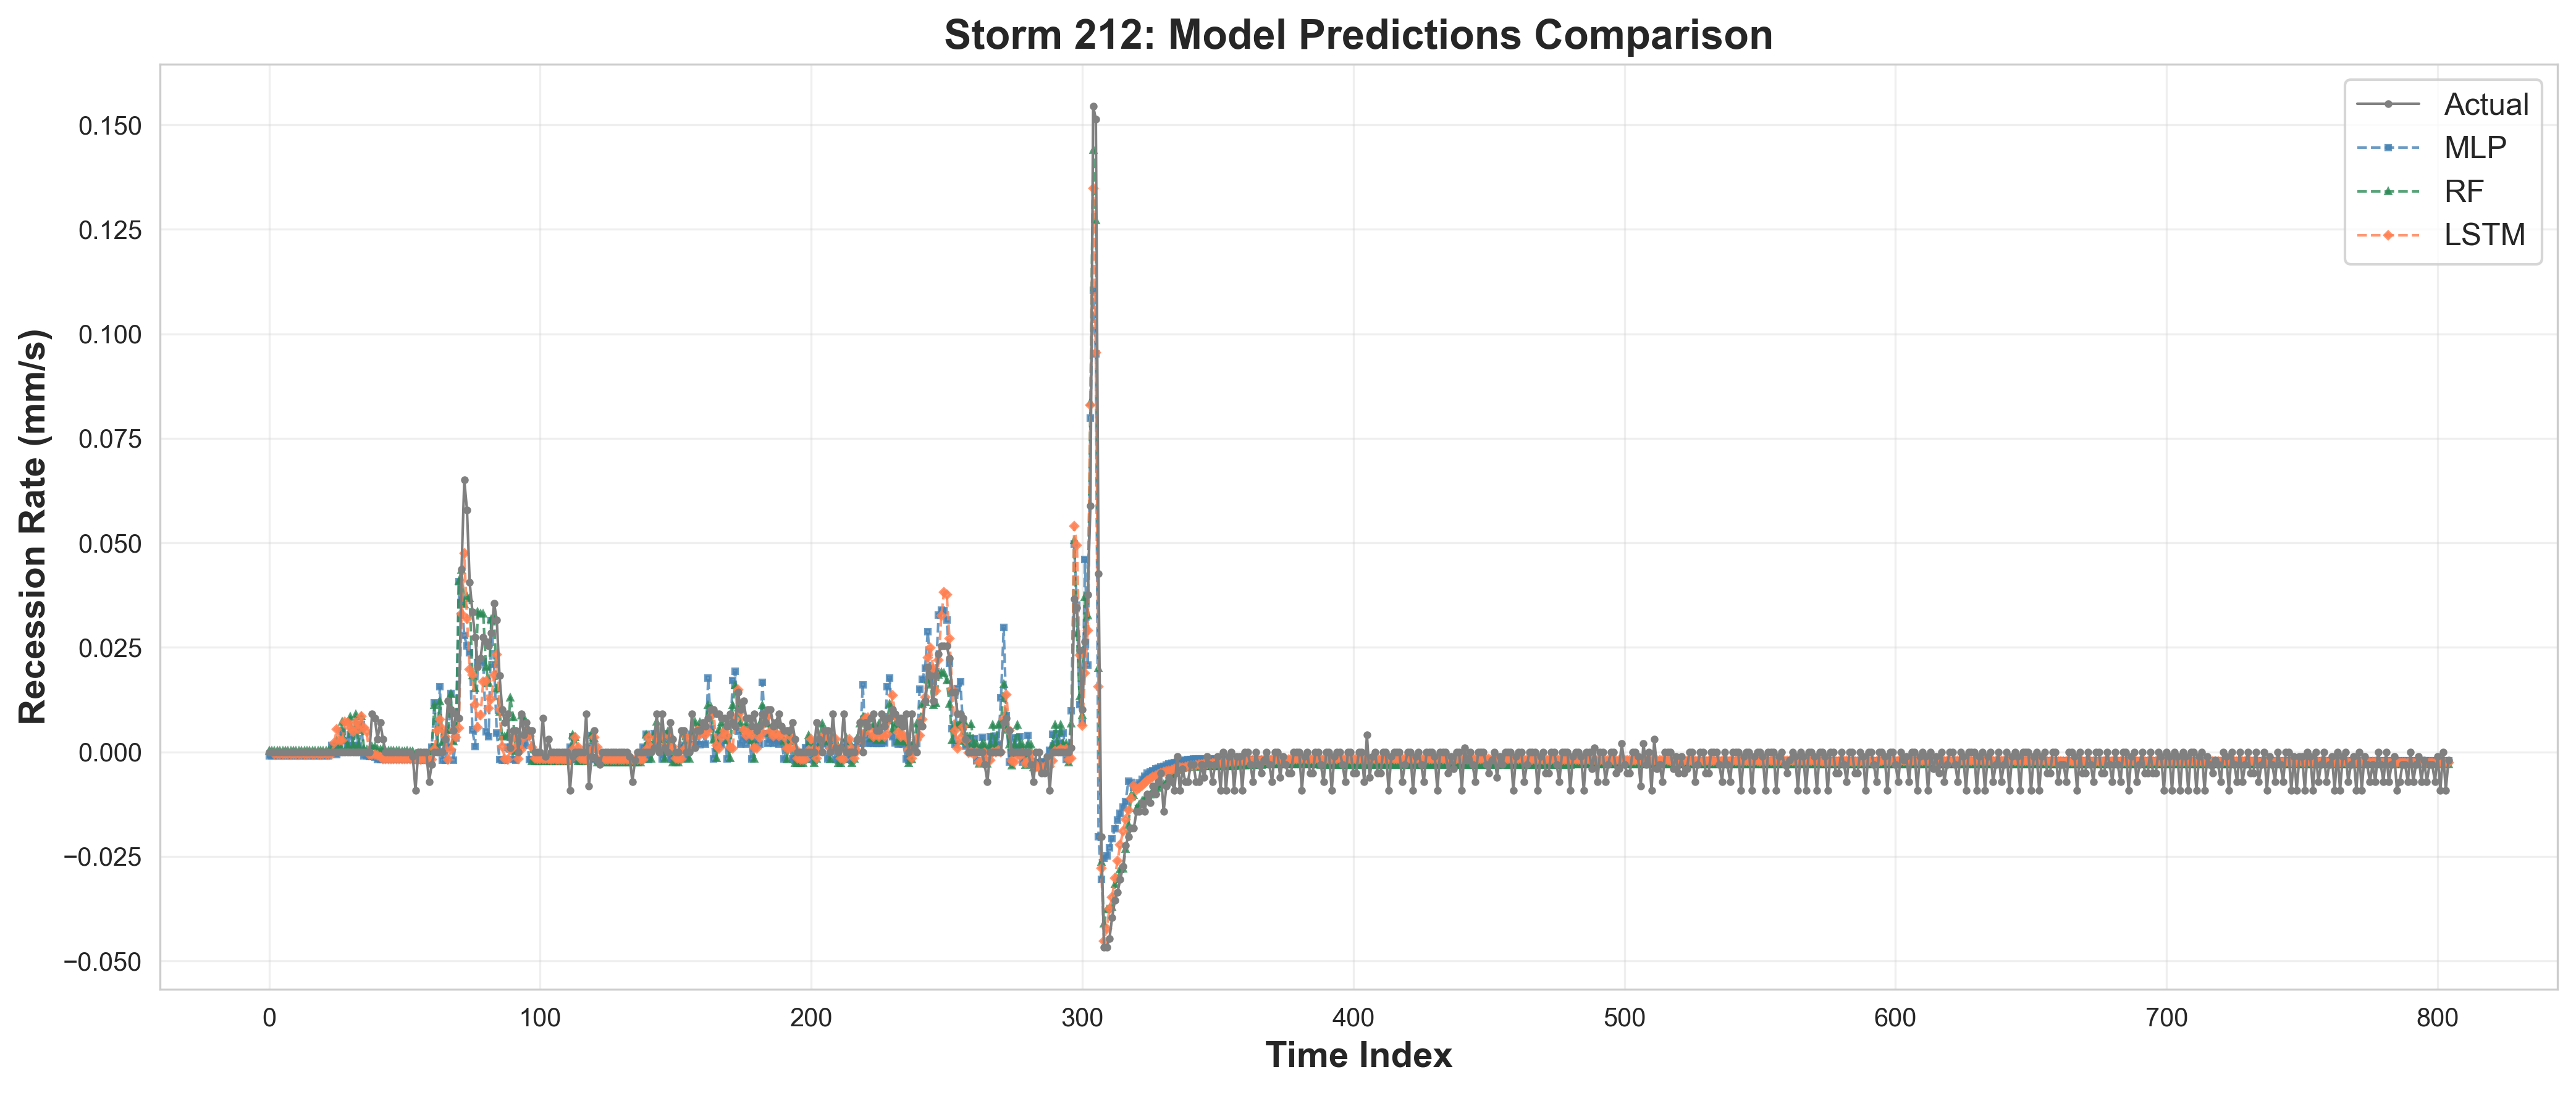

saved


In [32]:

# ============================================================================
# VISUALIZATION 3: TIME SERIES COMPARISON (SAMPLE STORM)
# ============================================================================


# Select a storm from test set 
storm_id = 212
storm_data = df[df['StormID'] == storm_id]

if len(storm_data) > 0:
    X_storm = storm_data[input_columns]
    y_storm = storm_data[target_column]
    X_storm_scaled = scaler.transform(X_storm)
    
    # MLP prediction
    X_storm_tensor = torch.FloatTensor(X_storm_scaled)
    with torch.no_grad():
        y_storm_pred_mlp = mlp_model(X_storm_tensor).numpy().flatten()
    
    # LSTM prediction
    if len(X_storm_scaled) > timesteps:
        X_storm_lstm = np.array([X_storm_scaled[i-timesteps:i] for i in range(timesteps, len(X_storm_scaled))])
        y_storm_lstm = y_storm.iloc[timesteps:]
        y_storm_pred_lstm = lstm_model.predict(X_storm_lstm, verbose=0).flatten()
    else:
        y_storm_lstm = None
        y_storm_pred_lstm = None
    
    # RF prediction
    y_storm_pred_rf = rf_model.predict(X_storm_scaled)
    
    # Plot
    fig, ax = plt.subplots(figsize=(14, 6))
    
    x_indices = np.arange(len(y_storm))
    ax.plot(x_indices, y_storm, 'ko-', color='gray', linewidth=1, markersize=2, label='Actual', zorder=5)
    ax.plot(x_indices, y_storm_pred_mlp, 's--', color='steelblue', linewidth=1, 
            markersize=2, label='MLP', alpha=0.8)
    ax.plot(x_indices, y_storm_pred_rf, '^--', color='seagreen', linewidth=1, 
            markersize=2, label='RF', alpha=0.8)
    
    if y_storm_pred_lstm is not None:
        x_indices_lstm = np.arange(timesteps, len(y_storm))
        ax.plot(x_indices_lstm, y_storm_pred_lstm, 'D--', color='coral', linewidth=1, 
                markersize=2, label='LSTM', alpha=0.8)
    
    ax.set_xlabel('Time Index', fontsize=14, fontweight='bold')
    ax.set_ylabel('Recession Rate (mm/s)', fontsize=14, fontweight='bold')
    ax.set_title(f'Storm {storm_id}: Model Predictions Comparison', fontsize=16, fontweight='bold')
    ax.legend(fontsize=12, loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{FIGURE_DIR}/model_comparison_timeseries_storm{storm_id}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("saved")
else:
    print(f"Storm {storm_id} not found in test set")


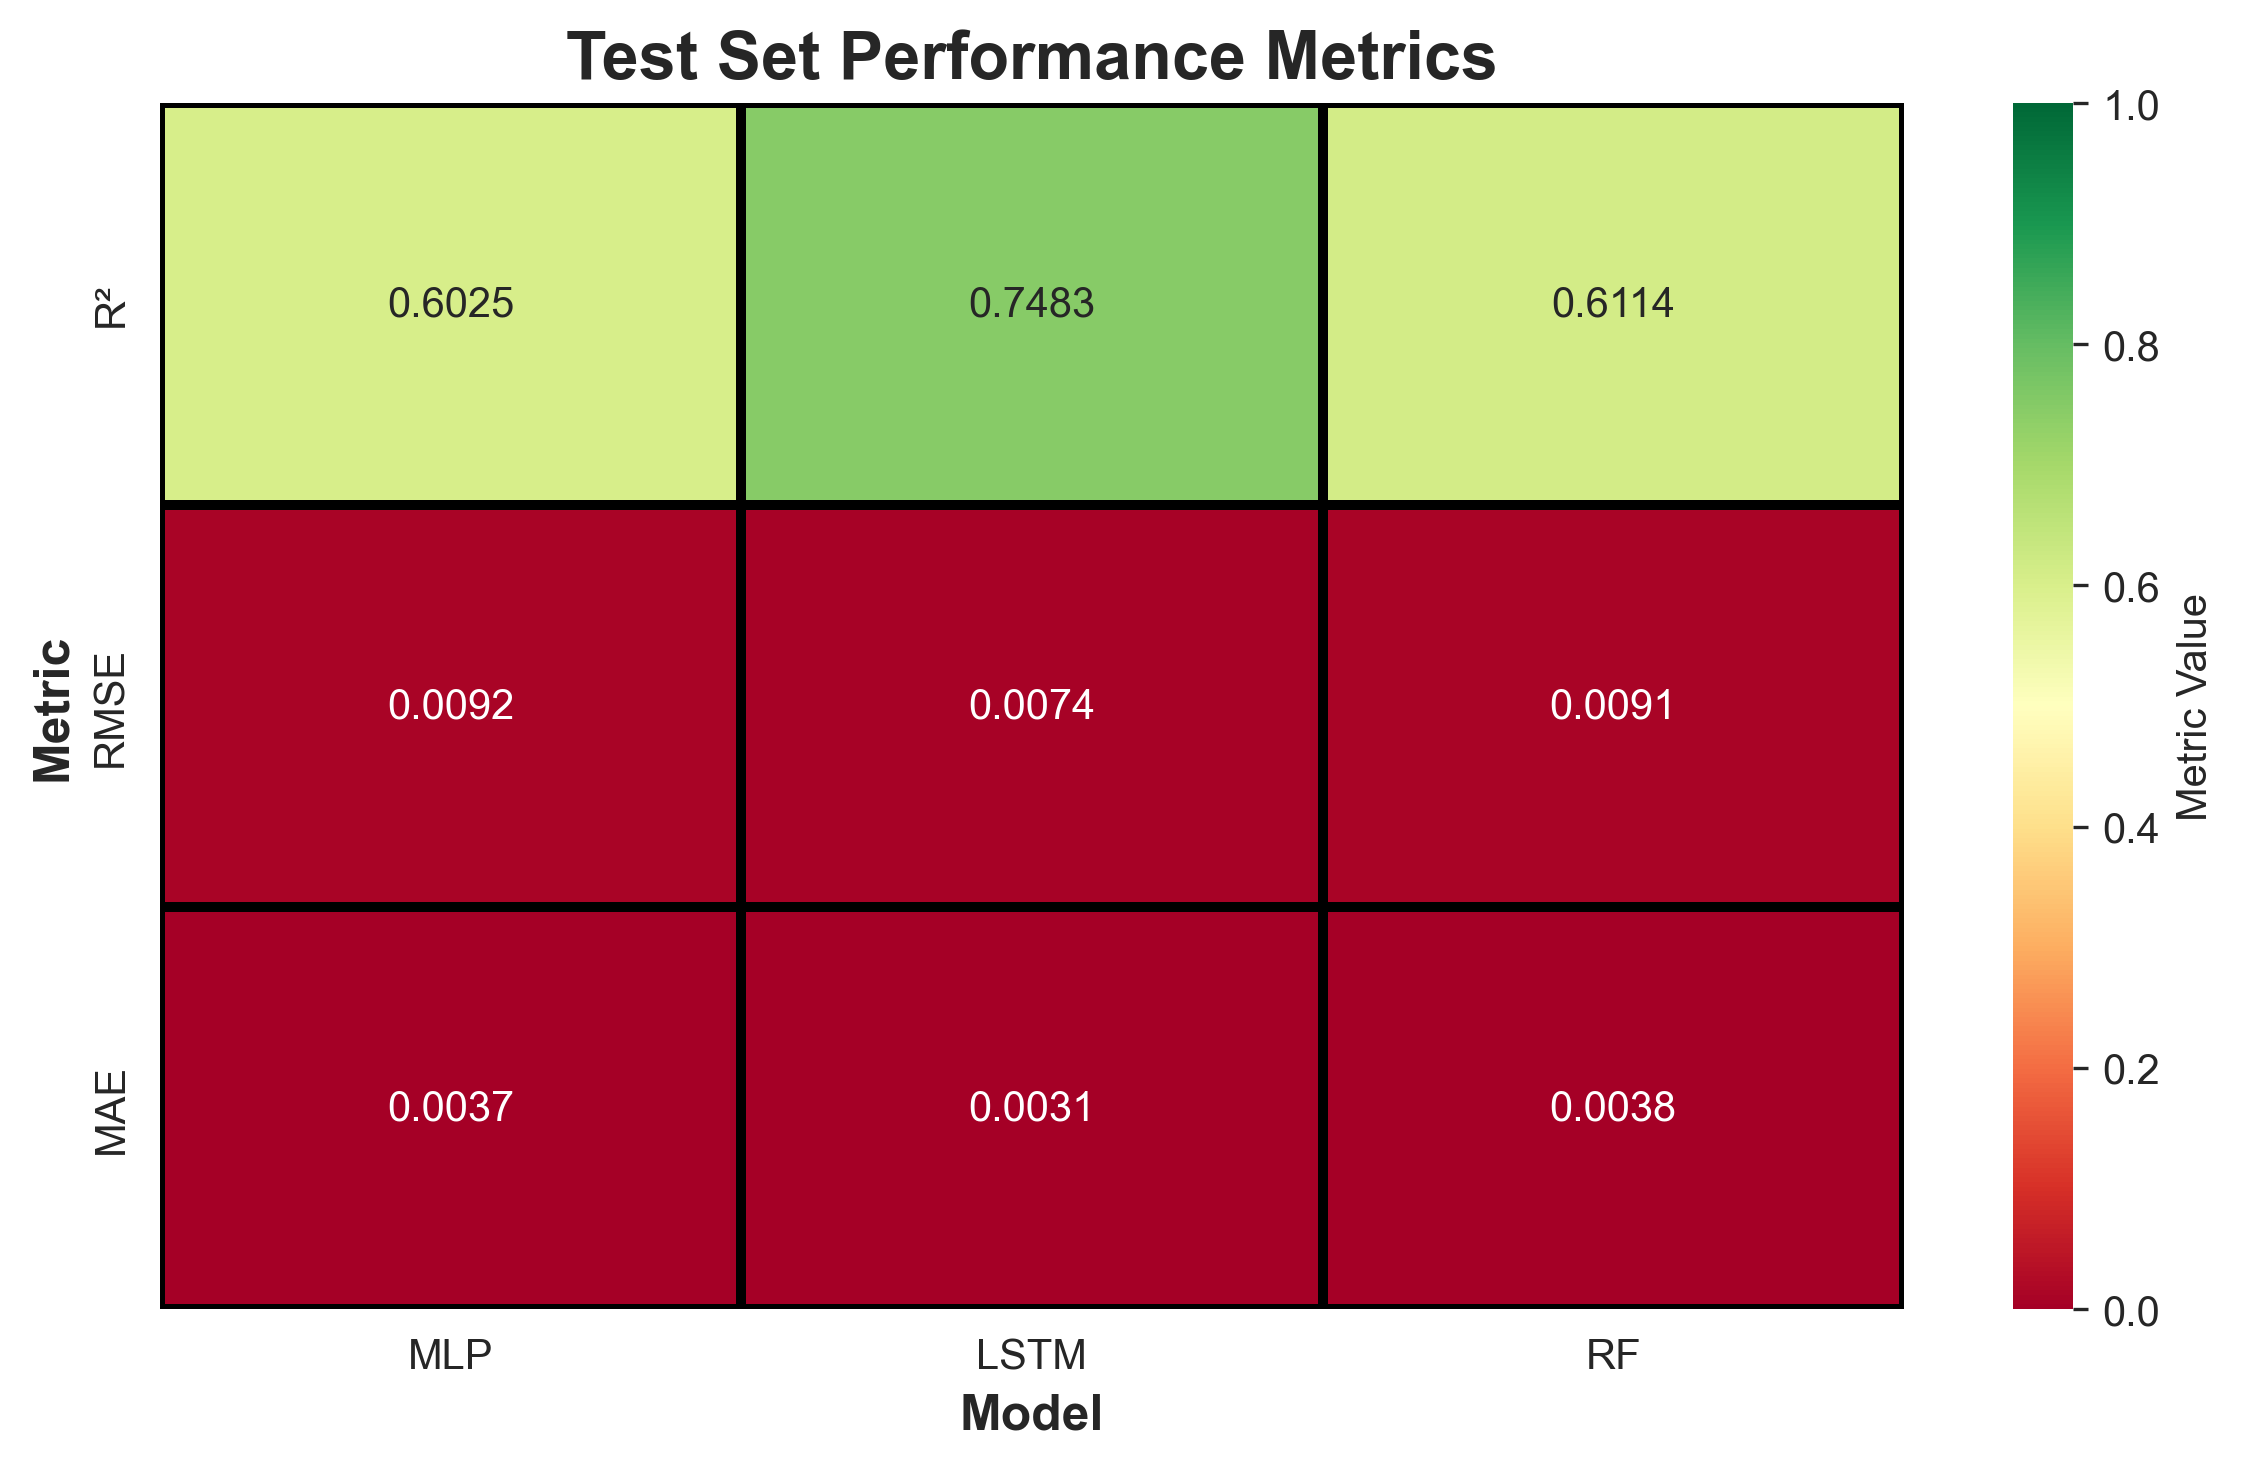

In [ ]:

# ============================================================================
# VISUALIZATION 4: METRICS HEATMAP 
# ============================================================================

# Prepare data for heatmap (Test set only)
test_metrics = results_df[results_df['Dataset'] == 'Test'][['Model', 'R²', 'RMSE', 'MAE']]
test_metrics_pivot = test_metrics.set_index('Model').T

fig, ax = plt.subplots(figsize=(8, 5))

# Normalize for better color scaling (invert RMSE and MAE so higher is better displayed)
test_metrics_display = test_metrics_pivot.copy()

# Create heatmap
sns.heatmap(test_metrics_display, annot=True, fmt='.4f', cmap='RdYlGn', 
            cbar_kws={'label': 'Metric Value'}, linewidths=2, linecolor='black',
            ax=ax, vmin=0, vmax=1)

ax.set_title('Test Set Performance Metrics', fontsize=16, fontweight='bold')
ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Metric', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{FIGURE_DIR}/model_comparison_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


In [27]:

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*80)
print("SUMMARY - TEST SET PERFORMANCE")
print("="*80)

test_summary = results_df[results_df['Dataset'] == 'Test'][['Model', 'R²', 'RMSE', 'MAE']]
print(test_summary.to_string(index=False))

# Find best model
best_model = test_summary.loc[test_summary['R²'].idxmax(), 'Model']
best_r2 = test_summary['R²'].max()

print(f"\n Best Model: {best_model} (R² = {best_r2:.4f})")
print("="*80)


SUMMARY - TEST SET PERFORMANCE
Model       R²     RMSE     MAE
  MLP 0.602459 0.009244 0.00374
 LSTM 0.748313 0.007356 0.00313
   RF 0.611408 0.009139 0.00376

 Best Model: LSTM (R² = 0.7483)


In [ ]:
### ============================================================================
# SHAP Analysis (Didn't work, I gave up)
# ============================================================================

import shap
feature_names = [
    'Temp_Air', 'Temp_Moist', 
    'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91',
    'Inflow', 'Overflow', 'Precipitation', 
    'Previous_Dry_Days', 'Accumulated_Rain', 'Peak_Rain', 'Mean_Rain'
]

# Use a sample of test data for SHAP (100 samples for speed)
sample_size = min(100, len(X_test))
sample_indices = np.random.choice(len(X_test), sample_size, replace=False)


C:\Users\cario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [42]:

# ============================================================================
#  MLP
# ============================================================================


# Prepare data (exclude StormID column - last column)
X_test_sample_mlp = X_test_scaled[sample_indices]
X_test_background_mlp = X_test_scaled[:100]  # Background dataset

# Compute SHAP values using DeepExplainer
explainer_mlp = shap.DeepExplainer(mlp_model, torch.FloatTensor(X_test_background_mlp))
shap_values_mlp = explainer_mlp.shap_values(torch.FloatTensor(X_test_sample_mlp))


In [43]:


# ============================================================================
#  LSTM
# ============================================================================

# For LSTM, we need to reshape the data
# Sample from LSTM test data
sample_indices_lstm = np.random.choice(len(X_test_lstm), min(100, len(X_test_lstm)), replace=False)
X_test_sample_lstm = X_test_lstm[sample_indices_lstm]

X_test_sample_lstm_flat = X_test_sample_lstm[:, -1, :] 
X_test_background_lstm = X_test_lstm[:100, -1, :]

def lstm_predict_flat(x):
    """
    Reshape 2D input to LSTM's expected 3D format
    Input: (samples, features)
    Output: (samples, 1) predictions
    """
    batch_size = x.shape[0]
    n_features = x.shape[1]
    
    # Create 3D array: (samples, timesteps, features)
    x_reshaped = np.zeros((batch_size, timesteps, n_features))
    x_reshaped[:, -1, :] = x  # Put current features in last timestep
    
    return lstm_model.predict(x_reshaped, verbose=0)

# Use KernelExplainer for LSTM (more flexible)
explainer_lstm = shap.KernelExplainer(lstm_predict_flat, X_test_background_lstm)
shap_values_lstm = explainer_lstm.shap_values(X_test_sample_lstm_flat, nsamples=100)


100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


In [44]:

# ============================================================================
# RANDOM FOREST
# ============================================================================

X_test_sample_rf = X_test_scaled[sample_indices]  

explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test_sample_rf)


IndexError: list index out of range

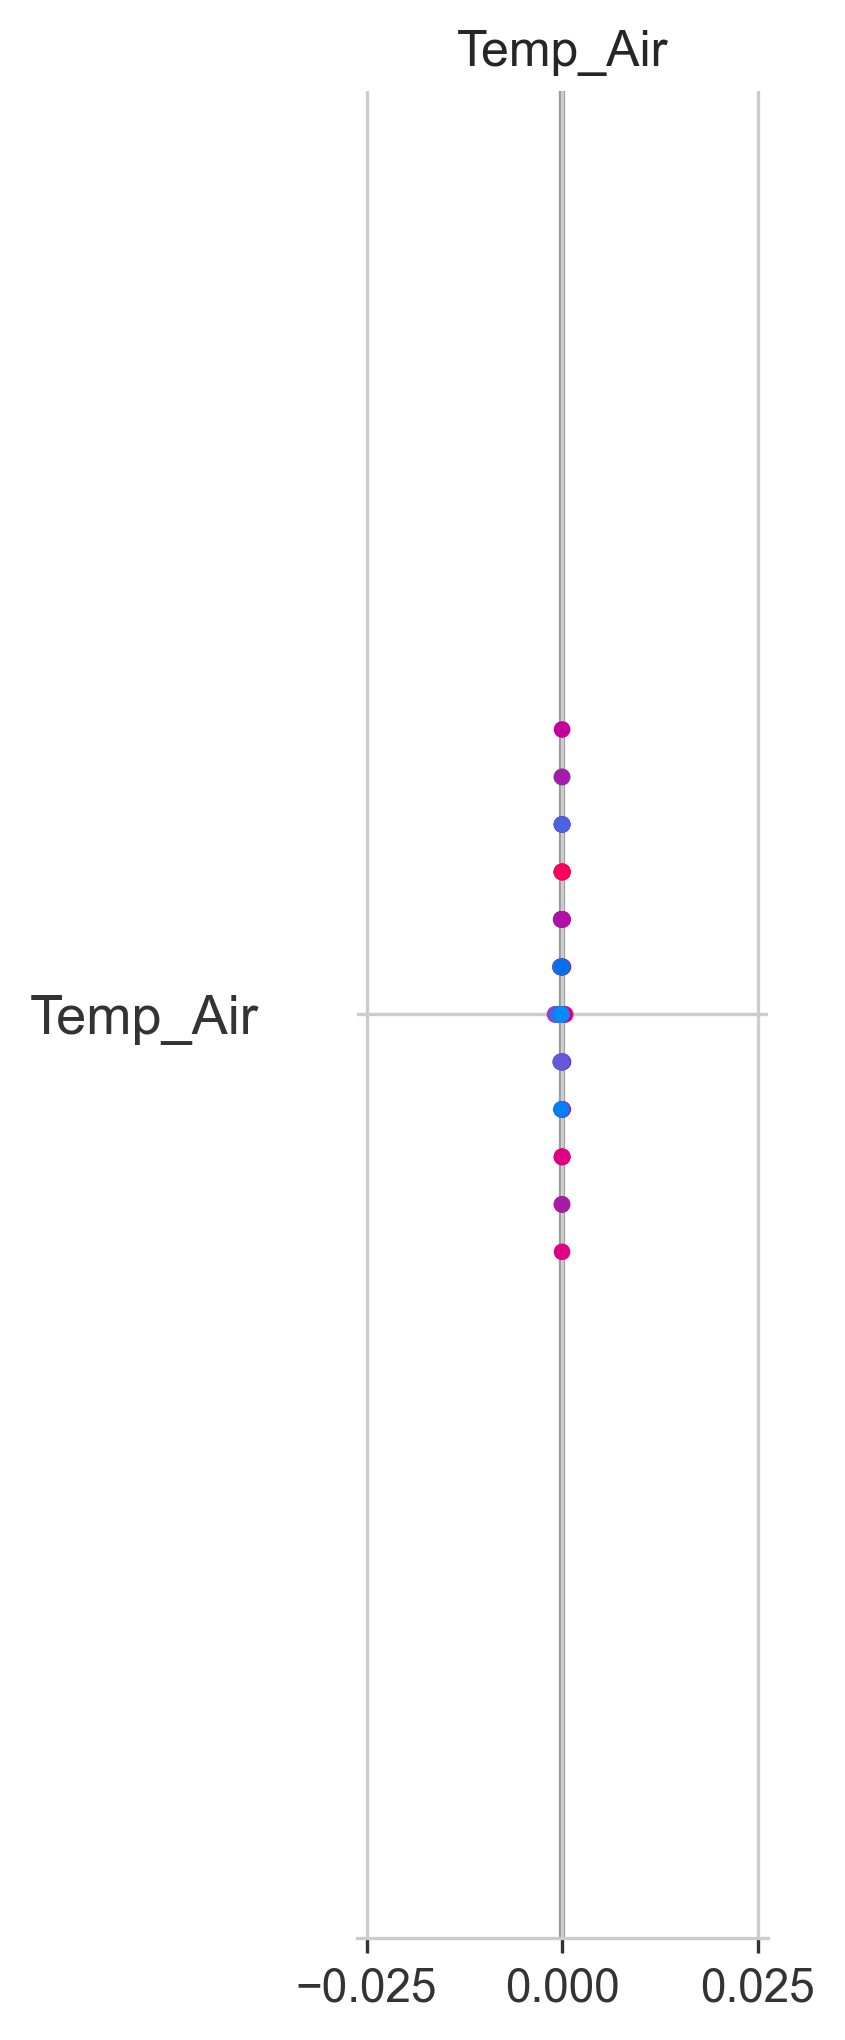

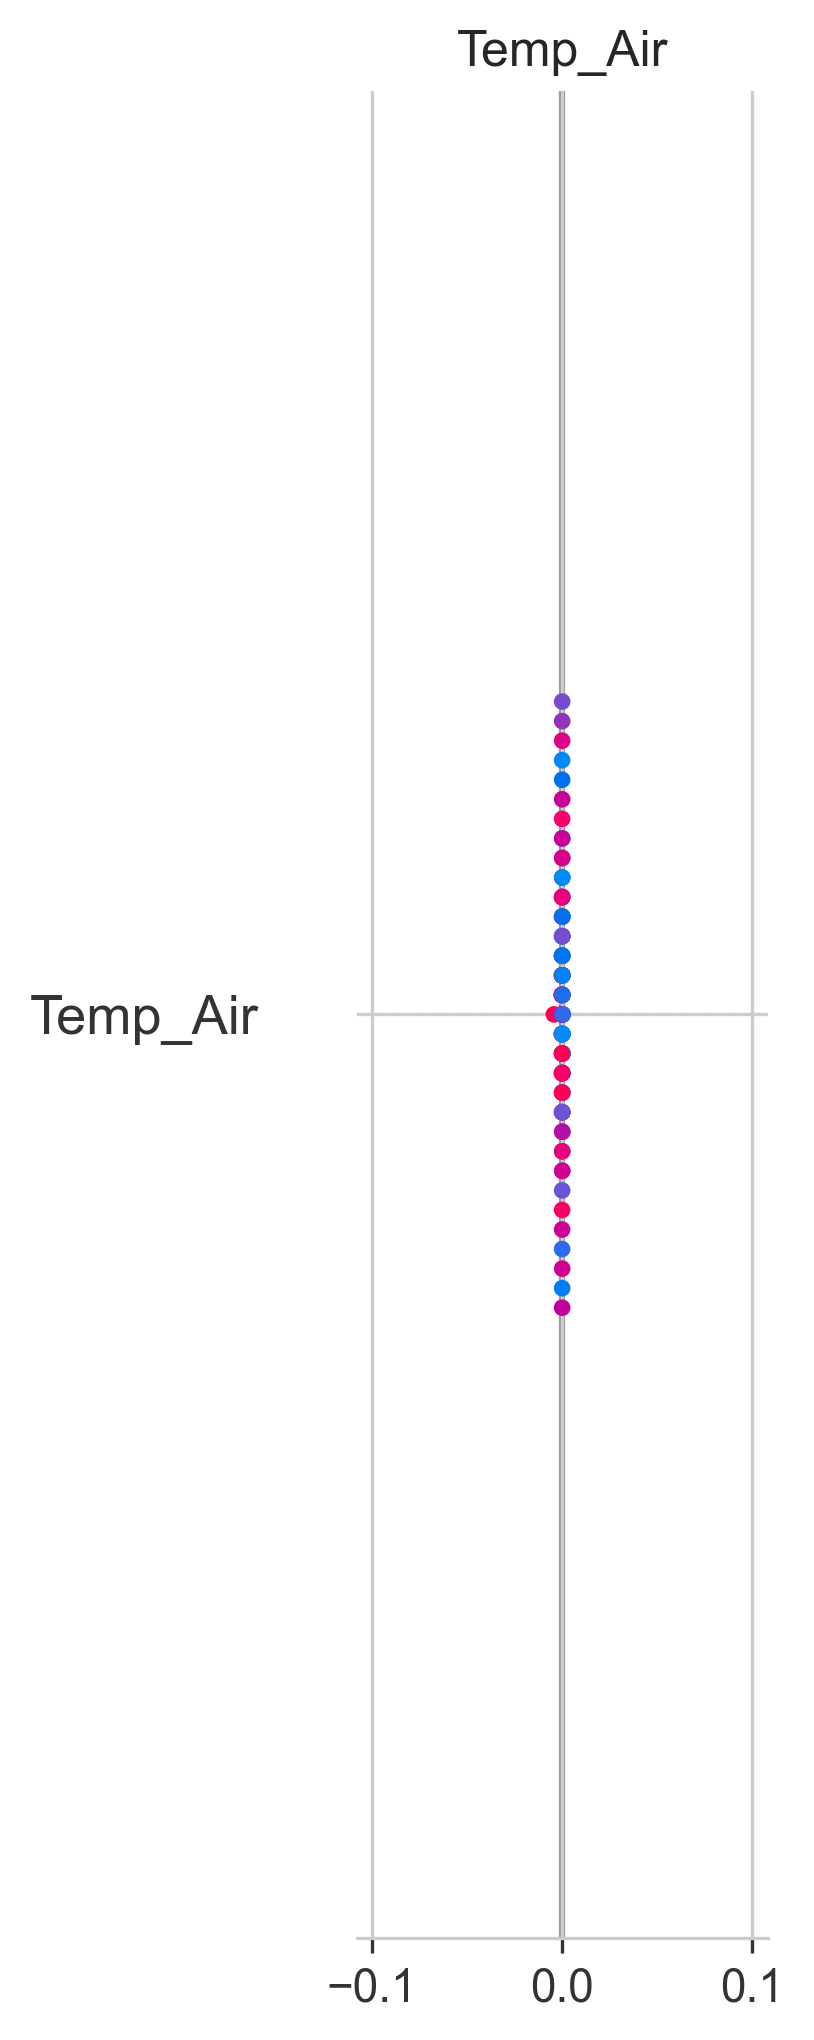

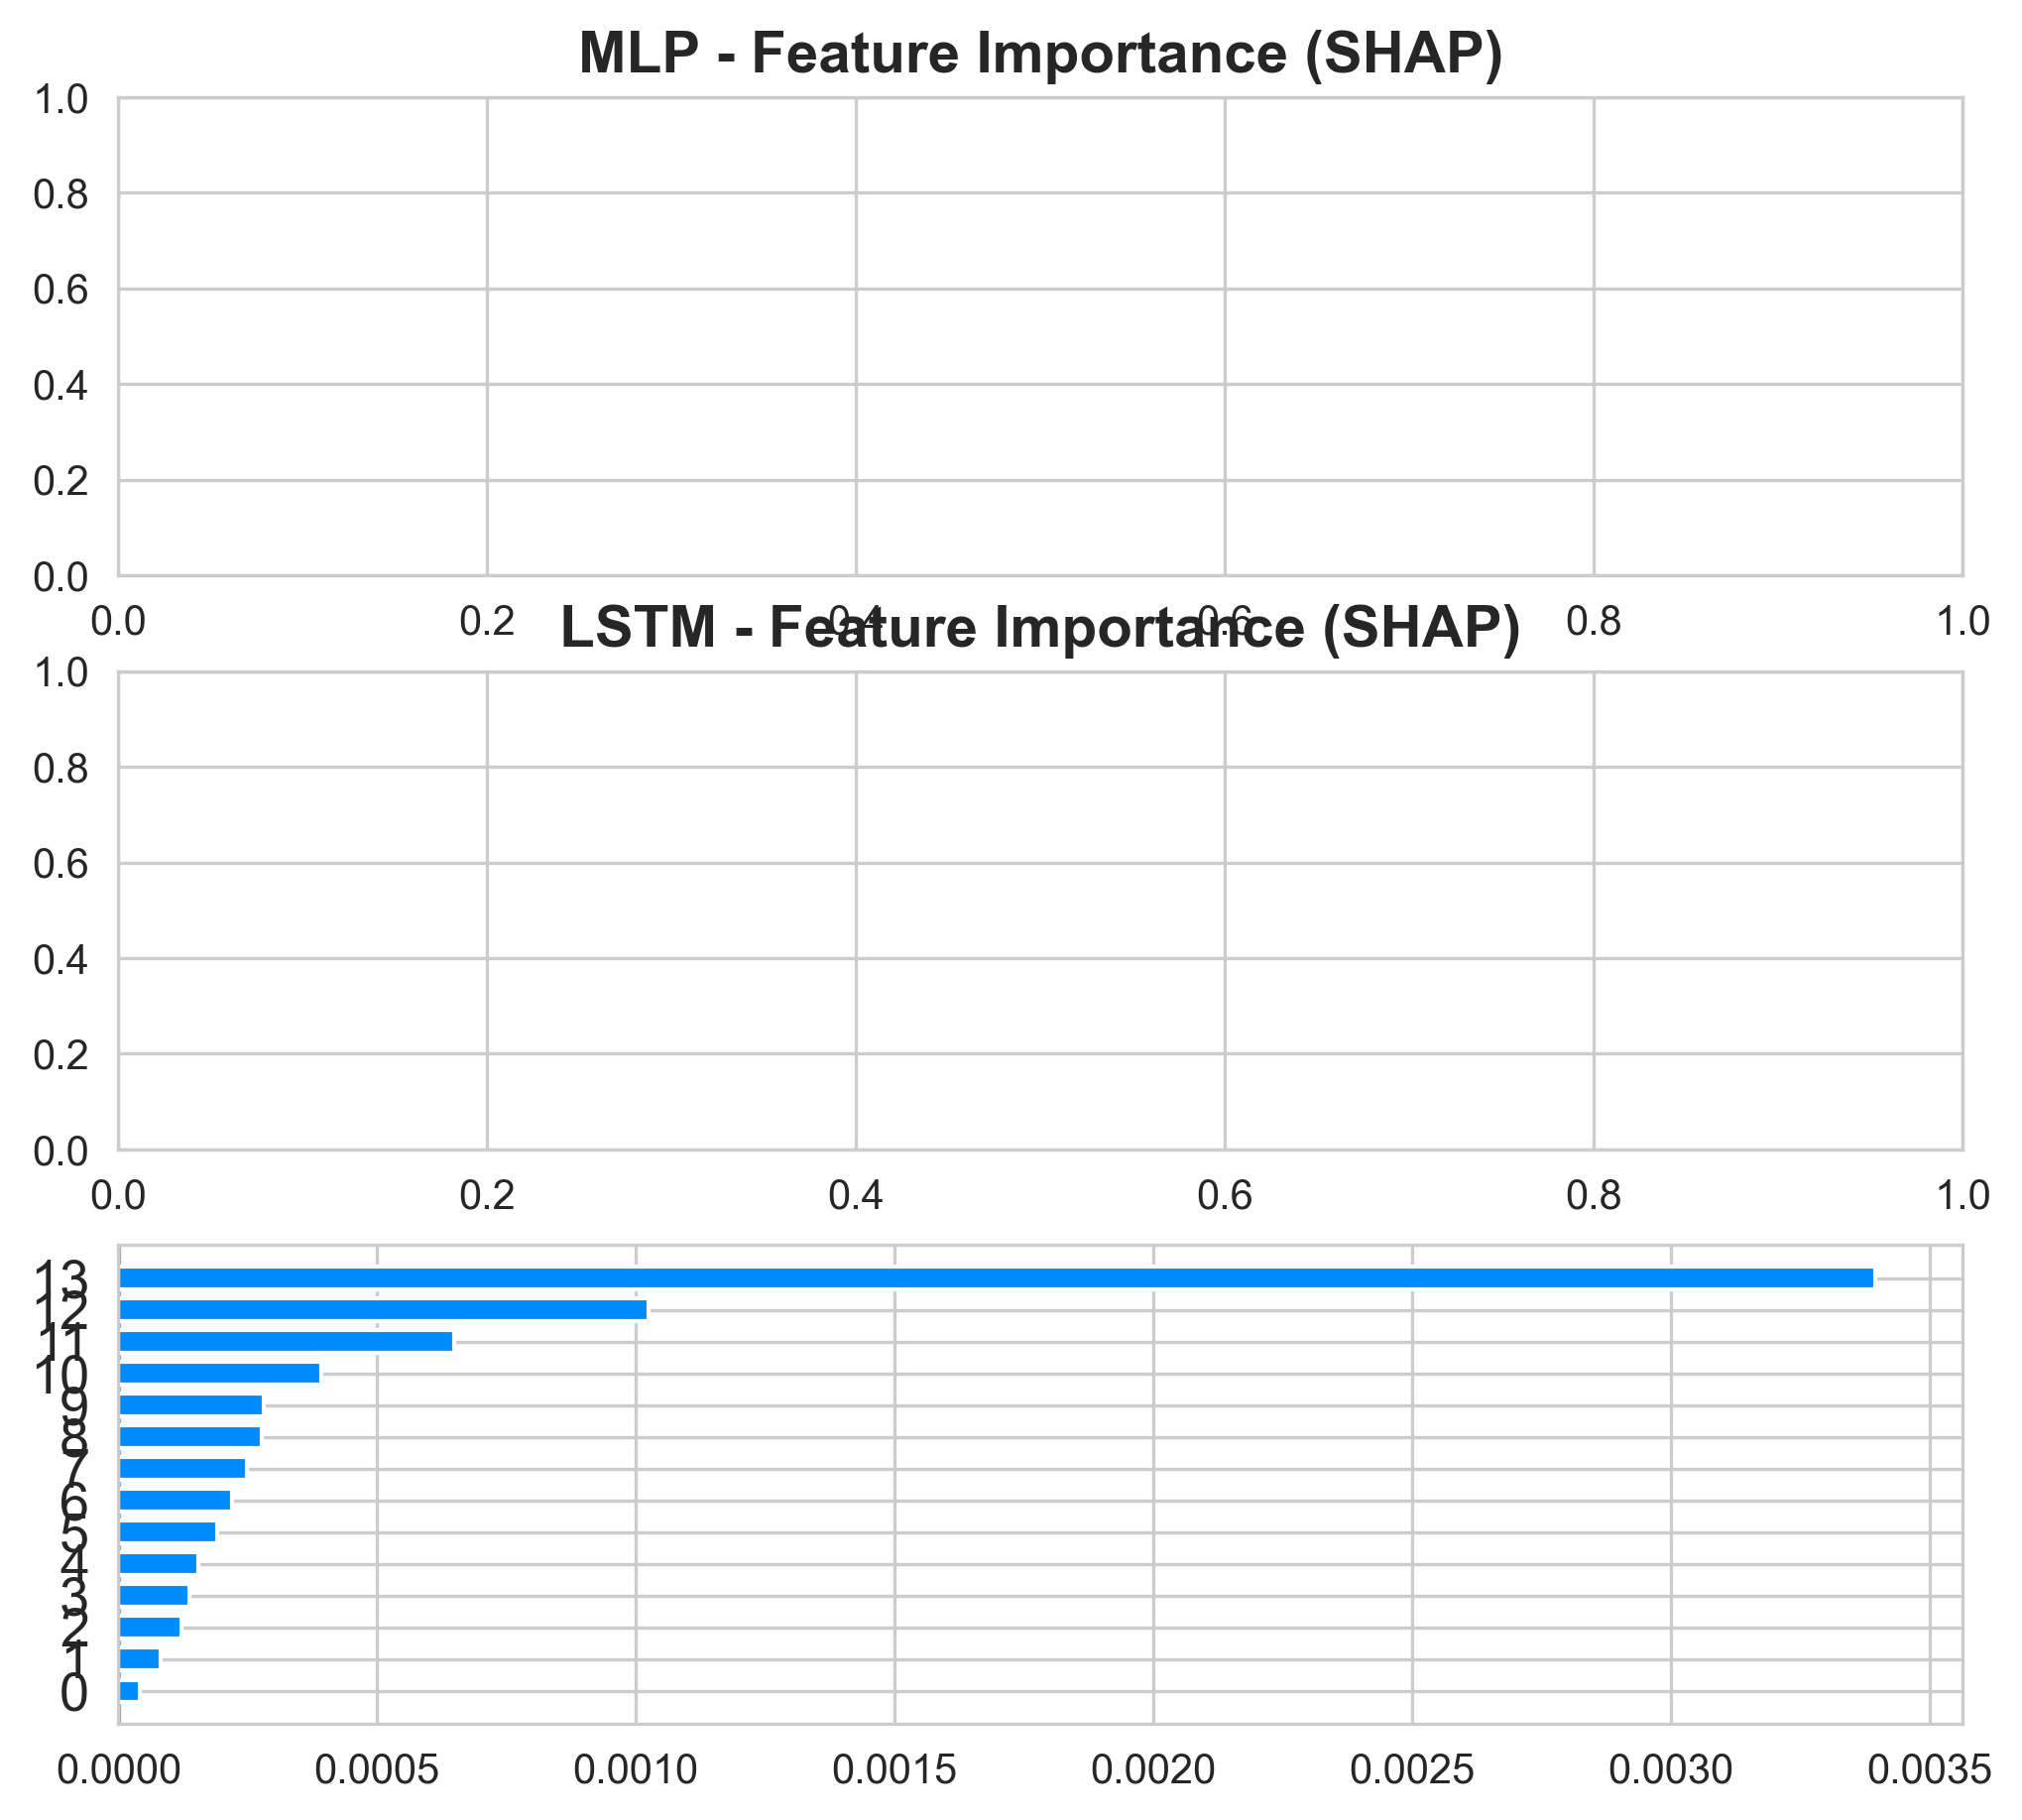

In [45]:

# ============================================================================
# VISUALIZATION: SHAP SUMMARY PLOTS
# ============================================================================

# Create figure with 3 subplots (one for each model)
fig, axes = plt.subplots(3, 1, figsize=(12, 14))

#MLP SHAP Summary
plt.sca(axes[0])
shap.summary_plot(shap_values_mlp, X_test_sample_mlp, 
                  feature_names=feature_names,
                  plot_type="bar", show=False)
axes[0].set_title('MLP - Feature Importance (SHAP)', fontsize=14, fontweight='bold')

# LSTM SHAP Summary
plt.sca(axes[1])
shap.summary_plot(shap_values_lstm, X_test_sample_lstm_flat, 
                  feature_names=feature_names,
                  plot_type="bar", show=False)
axes[1].set_title('LSTM - Feature Importance (SHAP)', fontsize=14, fontweight='bold')

#  RF SHAP Summary
plt.sca(axes[2])
shap.summary_plot(shap_values_rf, X_test_sample_rf, 
                  feature_names=feature_names,
                  plot_type="bar", show=False)
axes[2].set_title('Random Forest - Feature Importance (SHAP)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{FIGURE_DIR}/model_comparison_shap_bar.png', dpi=300, bbox_inches='tight')
plt.show()


IndexError: list index out of range

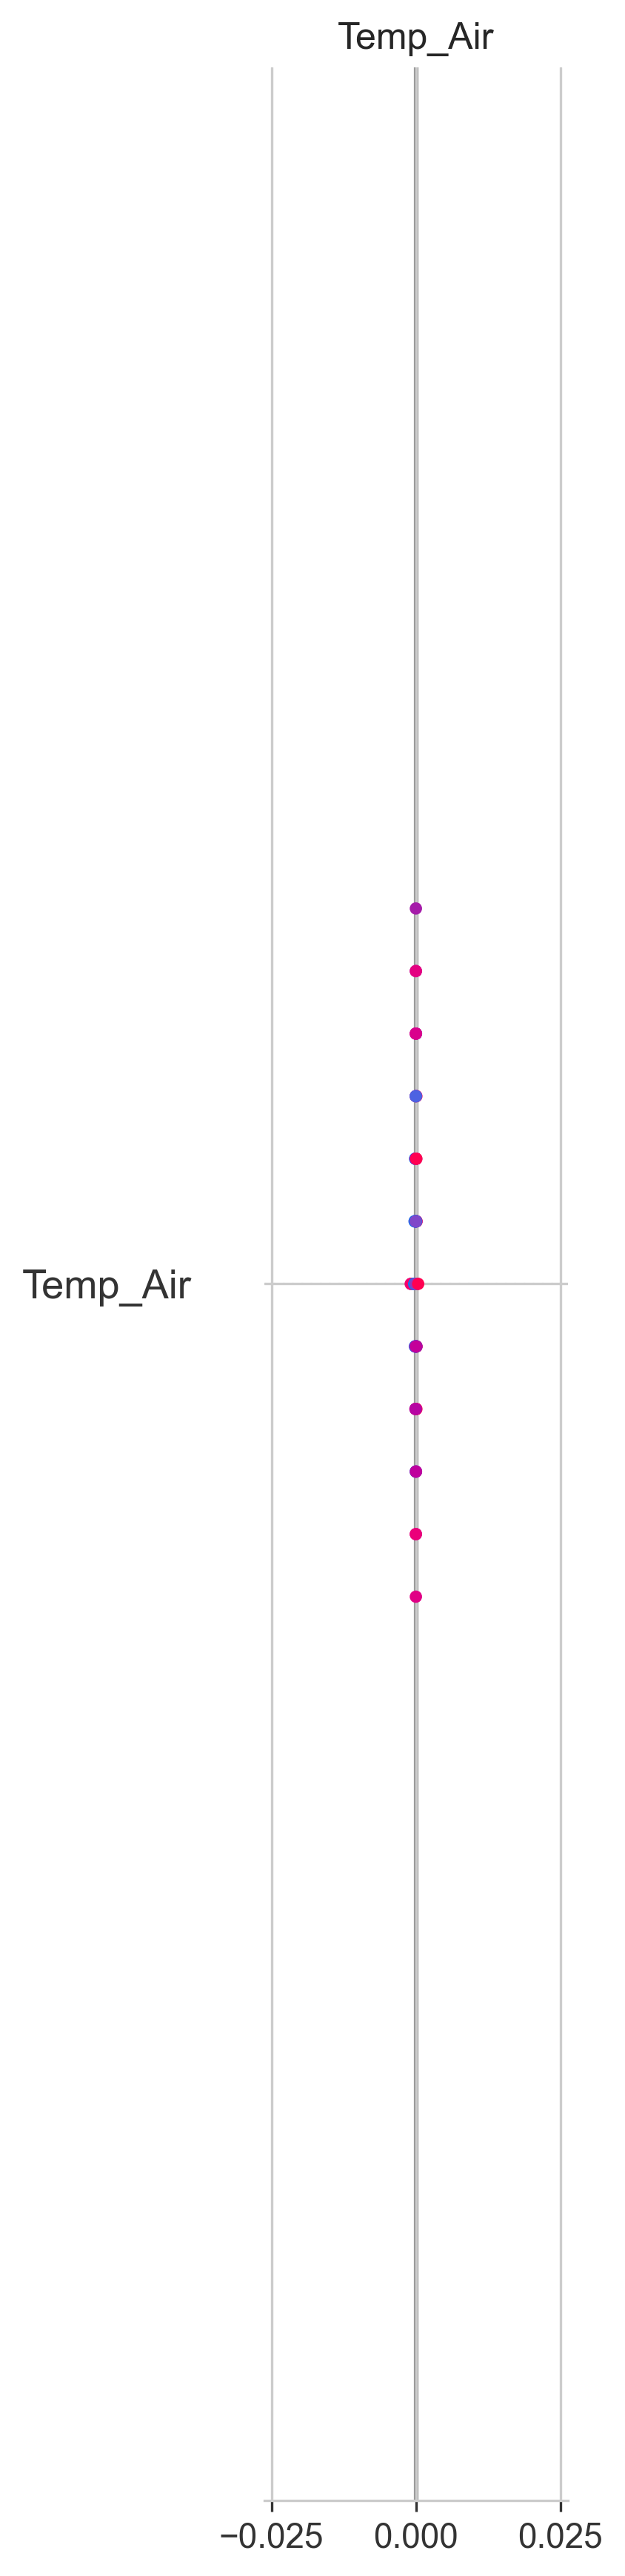

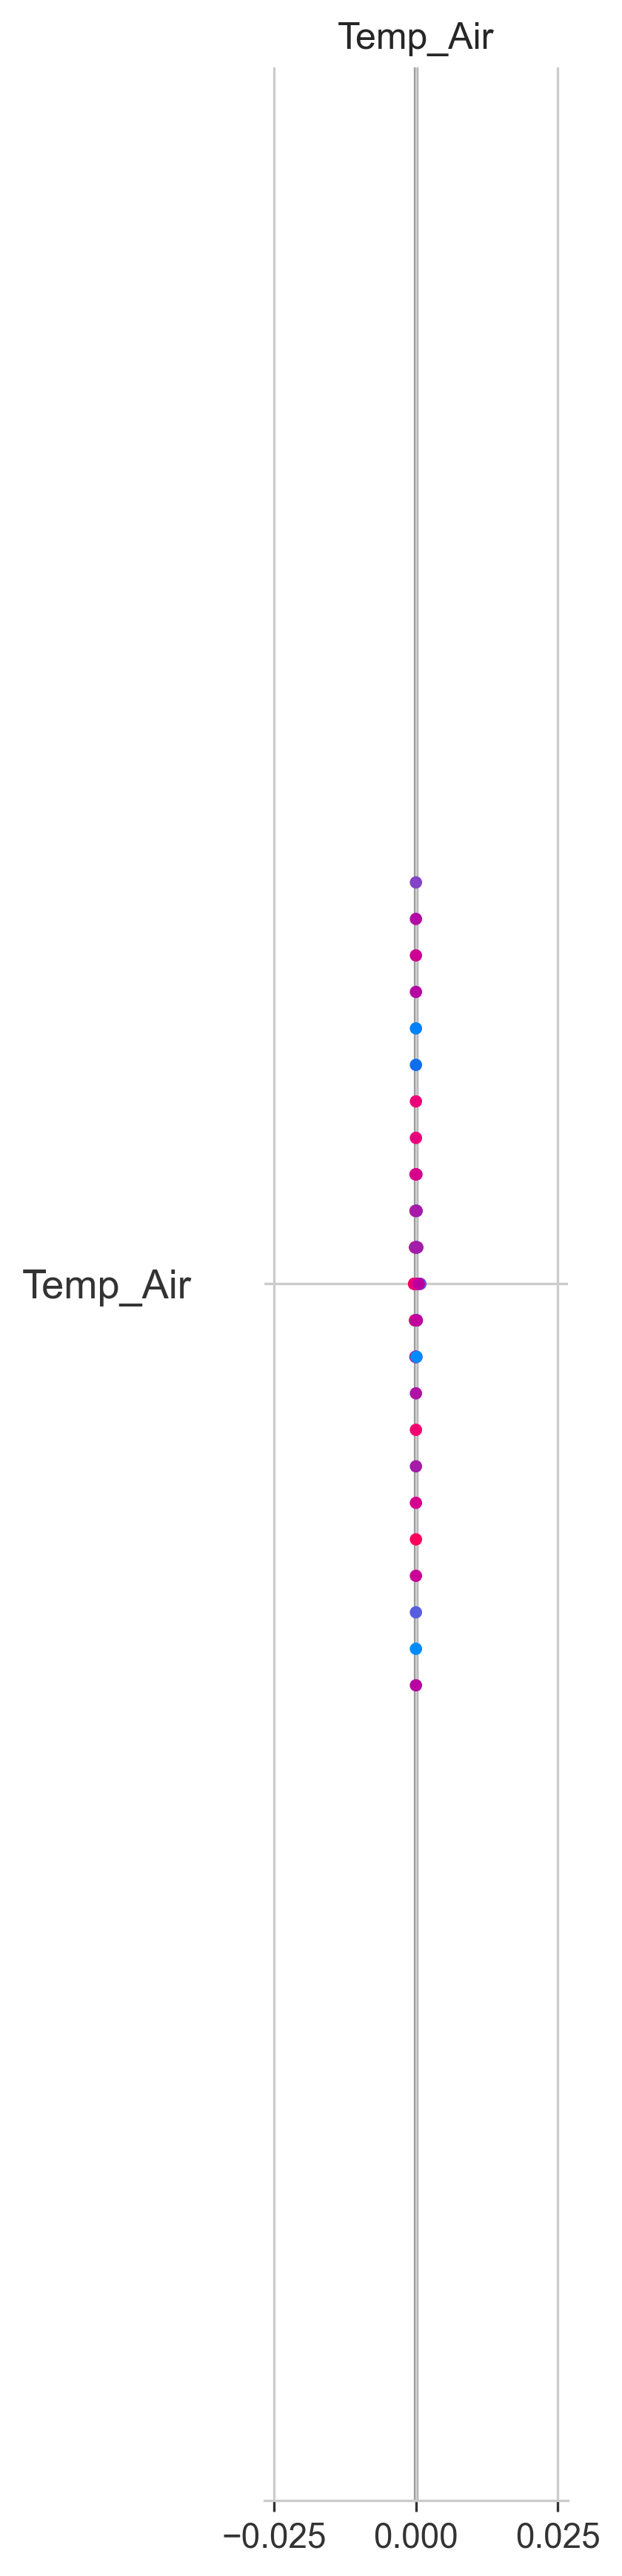

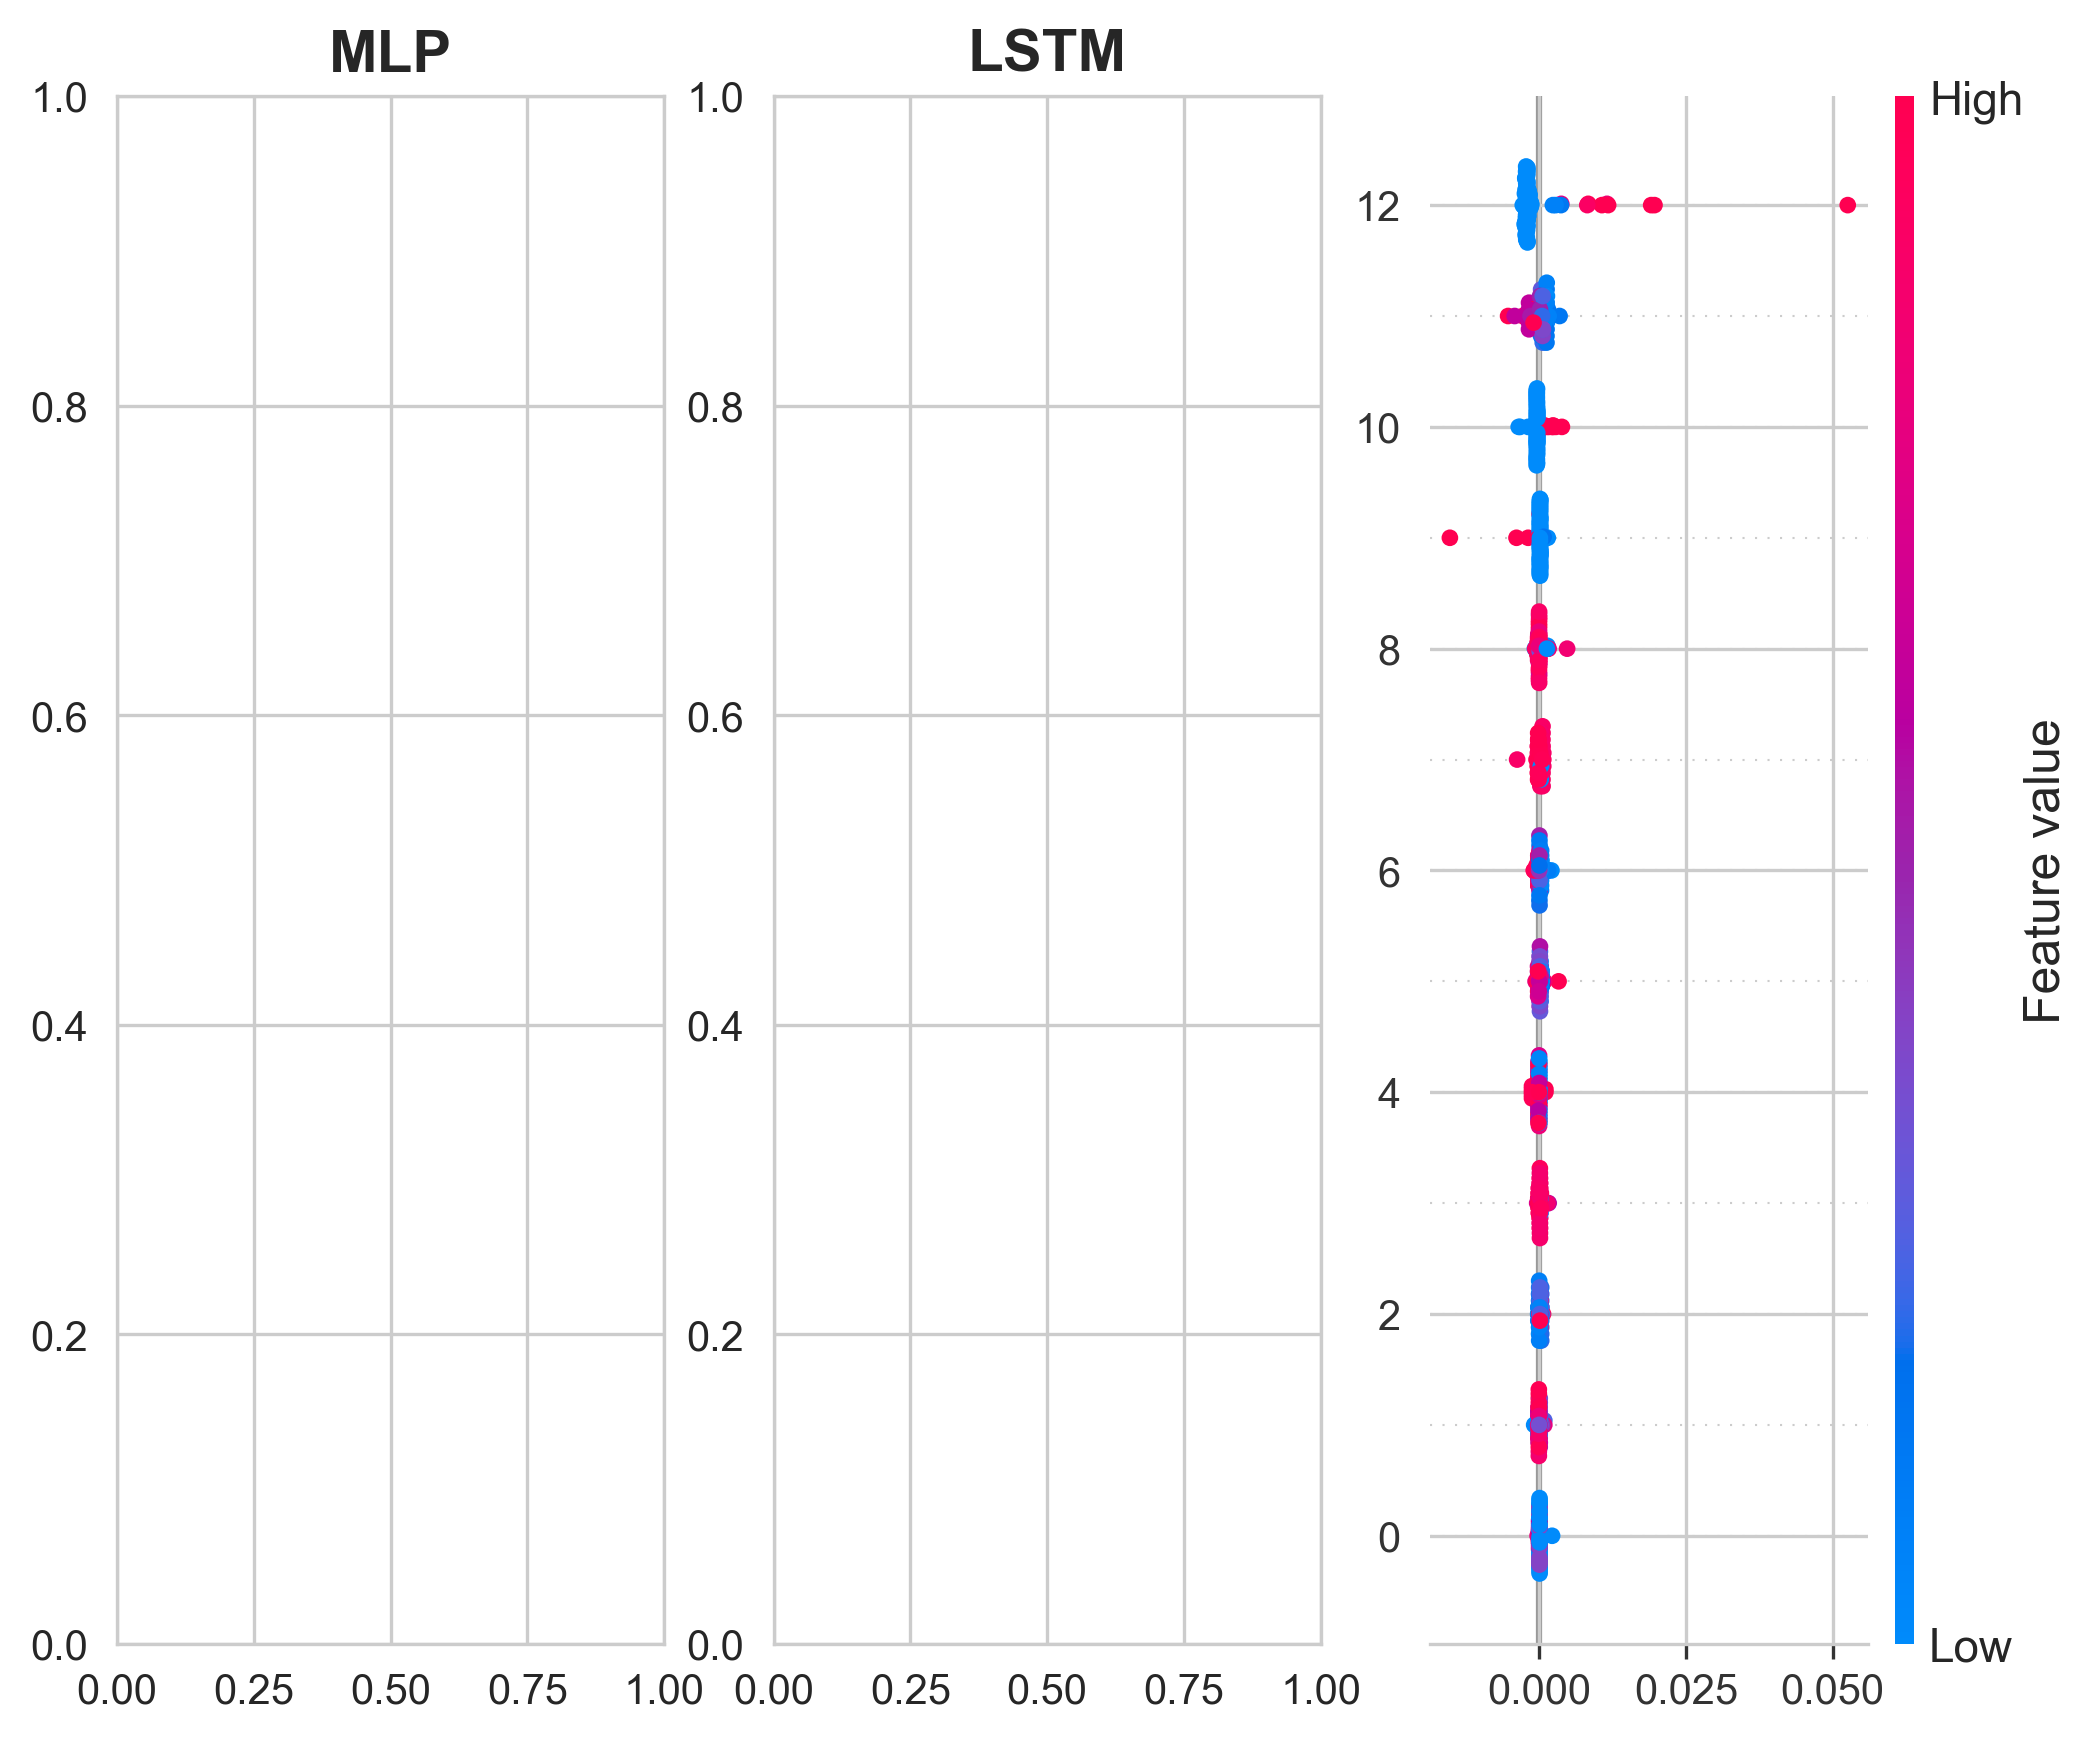

In [39]:

# ============================================================================
# VISUALIZATION: SHAP BEESWARM PLOTS (Detailed)
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. MLP Beeswarm
plt.sca(axes[0])
shap.summary_plot(shap_values_mlp, X_test_sample_mlp, 
                  feature_names=feature_names,
                  show=False, max_display=13)
axes[0].set_title('MLP', fontsize=14, fontweight='bold')

# 2. LSTM Beeswarm
plt.sca(axes[1])
shap.summary_plot(shap_values_lstm, X_test_sample_lstm_flat, 
                  feature_names=feature_names,
                  show=False, max_display=13)
axes[1].set_title('LSTM', fontsize=14, fontweight='bold')

# 3. RF Beeswarm
plt.sca(axes[2])
shap.summary_plot(shap_values_rf, X_test_sample_rf, 
                  feature_names=feature_names,
                  show=False, max_display=13)
axes[2].set_title('Random Forest', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{FIGURE_DIR}/model_comparison_shap_beeswarm.png', dpi=300, bbox_inches='tight')
plt.show()


In [40]:

# ============================================================================
# COMPUTE MEAN ABSOLUTE SHAP VALUES (FEATURE IMPORTANCE RANKING)
# ============================================================================

# Compute mean absolute SHAP values for each feature
def get_feature_importance(shap_vals, feature_names):
    mean_abs_shap = np.abs(shap_vals).mean(axis=0)
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': mean_abs_shap
    })
    return importance_df.sort_values('Importance', ascending=False)

mlp_importance = get_feature_importance(shap_values_mlp, feature_names)
lstm_importance = get_feature_importance(shap_values_lstm, feature_names)
rf_importance = get_feature_importance(shap_values_rf, feature_names)

print("\n--- MLP Top 5 Features ---")
print(mlp_importance.head().to_string(index=False))

print("\n--- LSTM Top 5 Features ---")
print(lstm_importance.head().to_string(index=False))

print("\n--- Random Forest Top 5 Features ---")
print(rf_importance.head().to_string(index=False))


ValueError: Per-column arrays must each be 1-dimensional

In [41]:

# ============================================================================
# VISUALIZATION: COMPARISON OF TOP FEATURES
# ============================================================================
# Combine all importances
mlp_importance['Model'] = 'MLP'
lstm_importance['Model'] = 'LSTM'
rf_importance['Model'] = 'RF'

all_importance = pd.concat([mlp_importance, lstm_importance, rf_importance])

# Pivot for grouped bar chart
importance_pivot = all_importance.pivot(index='Feature', columns='Model', values='Importance')
importance_pivot = importance_pivot.sort_values('MLP', ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(importance_pivot))
width = 0.25

bars1 = ax.bar(x - width, importance_pivot['MLP'], width, 
               label='MLP', color='steelblue', edgecolor='black', linewidth=1)
bars2 = ax.bar(x, importance_pivot['LSTM'], width, 
               label='LSTM', color='coral', edgecolor='black', linewidth=1)
bars3 = ax.bar(x + width, importance_pivot['RF'], width, 
               label='RF', color='seagreen', edgecolor='black', linewidth=1)

ax.set_xlabel('Feature', fontsize=14, fontweight='bold')
ax.set_ylabel('Mean Absolute SHAP Value', fontsize=14, fontweight='bold')
ax.set_title('Feature Importance Comparison Across Models', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(importance_pivot.index, rotation=45, ha='right', fontsize=11)
ax.legend(fontsize=12)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{FIGURE_DIR}/model_comparison_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Save importance rankings to CSV
all_importance.to_csv(f'{FIGURE_DIR}/feature_importance_rankings.csv', index=False)

NameError: name 'mlp_importance' is not defined